In [27]:
import os
import glob
import cv2
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS

import matplotlib.pyplot as plt
import pandas as pd

import gmaps
import gmaps.datasets

In [2]:
## Set up five classes
catog = ['alfalfa','barley','corn','soybean','wheat']

In [3]:
## Initilize train and test set
x_train = np.empty((0,224,224,3),dtype='uint8')
x_test = np.empty((0,224,224,3),dtype='uint8')
y_train = np.empty((0,5),dtype='uint8')
y_test = np.empty((0,5),dtype='uint8')

In [4]:
## Read images from subdirectory in dir 'imags_de'
## In each class, choose first 2/3 images set as training set; the rest 1/3 images set as test set.
for i in range(len(catog)):
    datai = []
    for file in glob.glob('/Users/chaofeng/Desktop/imgs_de/' + catog[i] + '/*.jpg'):
        im = cv2.imread(file)
        im2 = cv2.resize(im, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        datai.append(im2)
    xi = np.concatenate([l[np.newaxis] for l in datai])
    print(xi.shape)
    yi = np.full((xi.shape[0],5), np.identity(5)[i])
    print(yi.shape)
    itrain_len = round(xi.shape[0]/3*2)
    itest_len = xi.shape[0] - itrain_len
    #print(itrain_len)
    #print(itest_len)
    xi_train = xi[:itrain_len]
    xi_test = xi[itrain_len:]
    print (xi_train.shape)
    print (xi_test.shape)
    yi_train = yi[:itrain_len]
    yi_test = yi[:itest_len]
    print (yi_train.shape)
    print (yi_test.shape)
    print('---------------------')
    #x_train = np.vstack((x_train, xi_train))
    #result_array = np.append(result_array, [result], axis=0)
    #x_train1.append(xi_train)
    #x_train = np.stack((x_train, xi_train))
    x_train = np.concatenate([x_train, xi_train], axis=0)
    x_test = np.concatenate([x_test, xi_test], axis=0)
    y_train = np.concatenate([y_train, yi_train], axis=0)
    y_test = np.concatenate([y_test, yi_test], axis=0)

(41, 224, 224, 3)
(41, 5)
(27, 224, 224, 3)
(14, 224, 224, 3)
(27, 5)
(14, 5)
---------------------
(39, 224, 224, 3)
(39, 5)
(26, 224, 224, 3)
(13, 224, 224, 3)
(26, 5)
(13, 5)
---------------------
(48, 224, 224, 3)
(48, 5)
(32, 224, 224, 3)
(16, 224, 224, 3)
(32, 5)
(16, 5)
---------------------
(55, 224, 224, 3)
(55, 5)
(37, 224, 224, 3)
(18, 224, 224, 3)
(37, 5)
(18, 5)
---------------------
(47, 224, 224, 3)
(47, 5)
(31, 224, 224, 3)
(16, 224, 224, 3)
(31, 5)
(16, 5)
---------------------


In [6]:
## Apply data augmentation feature provided in keras lib
image_gen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rescale=1./255,
    rotation_range=15,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True)

#training the image preprocessing
image_gen.fit(x_train, augment=True)

In [7]:
## Build a convolutional neurual network model using keras lib 
# input: 1224, 224 images with 3 channels -> (224, 224, 3) tensors.
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(5, activation='softmax'))
model.add(Dense(5, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
## class used to collect history accuracy data. 
## Ref: https://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

In [9]:
history = AccuracyHistory()
myepoch = 10;mybatchsize=64
##Train the cnn model
model.fit_generator(image_gen.flow(x_train, y_train, batch_size=mybatchsize),
                    steps_per_epoch = x_train.shape[0]//mybatchsize,
                    epochs=myepoch,
                    verbose=1,
                    validation_data=(x_test, y_test),callbacks=[history])

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
2/2 [==============================] - 21s 11s/step - loss: 1.6380 - acc: 0.2266 - val_loss: 12.3502 - val_acc: 0.2338
Epoch 2/10
2/2 [==============================] - 12s 6s/step - loss: 1.5872 - acc: 0.2815 - val_loss: 12.3502 - val_acc: 0.2338
Epoch 3/10
2/2 [==============================] - 11s 6s/step - loss: 1.6259 - acc: 0.2718 - val_loss: 11.1905 - val_acc: 0.2338
Epoch 4/10
2/2 [==============================] - 18s 9s/step - loss: 1.6094 - acc: 0.2500 - val_loss: 10.2532 - val_acc: 0.2338
Epoch 5/10
2/2 [==============================] - 13s 7s/step - loss: 1.6131 - acc: 0.2010 - val_loss: 9.3611 - val_acc: 0.3117
Epoch 6/10
2/2 [==============================] - 12s 6s/step - loss: 1.5795 - acc: 0.2099 - val_loss: 11.6079 - val_acc: 0.2208
Epoch 7/10
2/2 [==============================] - 17s 8s/step - loss: 1.5894 - acc: 0.2266 - val_loss: 12.3460 - val_acc: 0.2338
Epoch 8/10
2/2 [==============================] -

In [10]:
score = model.evaluate(x_test, y_test, batch_size=32, verbose=0)

In [11]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 11.213274695656516
Test accuracy: 0.2207792227144365


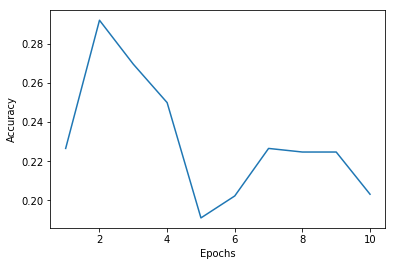

In [13]:
plt.plot(range(1,myepoch+1), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [17]:
## The following 4 functions is from: https://gist.github.com/erans/983821
# To save time, I directly apply functions here. This function are used to extract exif and return the floating number of lantitude and logitude.
def get_exif_data(image):
    """Returns a dictionary from the exif data of an PIL Image item. Also converts the GPS Tags"""
    exif_data = {}
    info = image._getexif()
    if info:
        for tag, value in info.items():
            decoded = TAGS.get(tag, tag)
            if decoded == "GPSInfo":
                gps_data = {}
                for t in value:
                    sub_decoded = GPSTAGS.get(t, t)
                    gps_data[sub_decoded] = value[t]

                exif_data[decoded] = gps_data
            else:
                exif_data[decoded] = value

    return exif_data

def _get_if_exist(data, key):
    if key in data:
        return data[key]
		
    return None
	
def _convert_to_degress(value):
    """Helper function to convert the GPS coordinates stored in the EXIF to degress in float format"""
    d0 = value[0][0]
    d1 = value[0][1]
    d = float(d0) / float(d1)

    m0 = value[1][0]
    m1 = value[1][1]
    m = float(m0) / float(m1)

    s0 = value[2][0]
    s1 = value[2][1]
    s = float(s0) / float(s1)

    return d + (m / 60.0) + (s / 3600.0)

def get_lat_lon(exif_data):
    """Returns the latitude and longitude, if available, from the provided exif_data (obtained through get_exif_data above)"""
    lat = None
    lon = None

    if "GPSInfo" in exif_data:		
        gps_info = exif_data["GPSInfo"]

        gps_latitude = _get_if_exist(gps_info, "GPSLatitude")
        gps_latitude_ref = _get_if_exist(gps_info, 'GPSLatitudeRef')
        gps_longitude = _get_if_exist(gps_info, 'GPSLongitude')
        gps_longitude_ref = _get_if_exist(gps_info, 'GPSLongitudeRef')

        if gps_latitude and gps_latitude_ref and gps_longitude and gps_longitude_ref:
            lat = _convert_to_degress(gps_latitude)
            if gps_latitude_ref != "N":                     
                lat = 0 - lat

            lon = _convert_to_degress(gps_longitude)
            if gps_longitude_ref != "E":
                lon = 0 - lon

    return lat, lon

In [18]:
## As step 1 of map geolocation data, read exif info of each image using PIL lib.
plist=[]
for filename in glob.iglob('/Users/chaofeng/Desktop/imgs_de/**', recursive=True):
    if os.path.isfile(filename): # filter dirs
        im = Image.open(filename)
        exif_data = get_exif_data(im)
        if exif_data is not None:
            (lan, lon) = get_lat_lon(exif_data)
            if lan is not None and lon is not None:
                l = list(get_lat_lon(exif_data))
                plist.append(l)
              

In [25]:
## Put all latitude and logitude info into a dataframe.
df = pd.DataFrame(plist,columns=['latitude','longitude'])
df

,latitude,longitude
0,40.554267,-88.988250
1,41.910733,-96.021378
2,41.911378,-96.021872
3,39.119514,-77.954681
4,39.140147,-77.327750
5,42.729314,-84.876769
6,39.721144,-92.156617
7,39.354808,-94.976372
8,41.404069,-85.521606
9,40.554267,-88.988250


In [1]:
###Real Google API is in school email.

In [2]:
## Use google map api to show all geolocations.
locations = df
gmaps.configure(api_key='XXXXXX')
fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locations))

NameError: name 'df' is not defined